In [1]:
import os
import json
import random
import collections

import numpy as np
import pandas as pd
import torch



import pycbc
import pycbc.psd
import pylab
from pycbc.psd import welch, interpolate

from scipy import signal
# from scipy.fft import fft, fftshift

import joblib
from tqdm.auto import tqdm
import shutil
import matplotlib.pyplot as plt
import torch


In [2]:
!du -sh ../data/*

100K	../data/avr_w0.pth
6.6M	../data/cma_ensemble_0.88307.csv
52K	../data/design_curves_tukey_0.2.npy
1023M	../data/ensemble-0916
3.0M	../data/fold0_oof_G2Net.csv
3.1M	../data/fold0_oof_GW.csv
6.9G	../data/GW_sim_300k.pkl
19M	../data/hack-lb
17M	../data/oof_8803.csv
19M	../data/oof_pred_cma_CV0.88307.csv
19M	../data/oofs_20210901-130913_CV-0.87749.csv
48K	../data/test_avg_psd.npy
48K	../data/train_avg_psd.npy


In [3]:
class Config:
    input_train = '/media/vincentwang/Backup/kaggle_data/g2net-gravitational-wave-detection/train/'
    input_test =  '/media/vincentwang/Backup/kaggle_data/g2net-gravitational-wave-detection/test/'
    output_folder_train =  '../data/train-float32/'
    output_folder_test = '../data/test-float32/'    
    debugging_mode = False
    whiten_train = False#generate whitened training data or not
    whiten_test= False#generate whitened testing data or not
    #whiten params
    window = 'tukey'
    alpha = 0.5
    fp16 = False
np.set_printoptions(precision=7, suppress=False) 

In [4]:
if not os.path.isdir(Config.output_folder_train):
    !mkdir -p $Config.output_folder_train
if not os.path.isdir(Config.output_folder_test):
    !mkdir -p $Config.output_folder_test

In [5]:
def get_train_file_path(image_id):
    return "{}/{}/{}/{}/{}.npy".format(Config.input_train, image_id[0], image_id[1], image_id[2], image_id)
def get_test_file_path(image_id):
    return "{}/{}/{}/{}/{}.npy".format(Config.input_test, image_id[0], image_id[1], image_id[2], image_id)

train = pd.read_csv(f'../data/training_labels.csv')
train['file_path'] = train['id'].apply(get_train_file_path)
test = pd.read_csv(f'../data/sample_submission.csv')
test['file_path'] = test['id'].apply(get_test_file_path)
display(train.head())
display(test.head())

,id,target,file_path
0,00000e74ad,1,/media/vincentwang/Backup/kaggle_data/g2net-gr...
1,00001f4945,0,/media/vincentwang/Backup/kaggle_data/g2net-gr...
2,0000661522,0,/media/vincentwang/Backup/kaggle_data/g2net-gr...
3,00007a006a,0,/media/vincentwang/Backup/kaggle_data/g2net-gr...
4,0000a38978,1,/media/vincentwang/Backup/kaggle_data/g2net-gr...


,id,target,file_path
0,00005bced6,0.5,/media/vincentwang/Backup/kaggle_data/g2net-gr...
1,0000806717,0.5,/media/vincentwang/Backup/kaggle_data/g2net-gr...
2,0000ef4fe1,0.5,/media/vincentwang/Backup/kaggle_data/g2net-gr...
3,00020de251,0.5,/media/vincentwang/Backup/kaggle_data/g2net-gr...
4,00024887b5,0.5,/media/vincentwang/Backup/kaggle_data/g2net-gr...


In [6]:
if Config.debugging_mode:
    if Config.whiten_train:
        train = train[:5000]
        print(len(train))
    if Config.whiten_test:
        test = test[:5000]
        print(len(test))

In [7]:
def save_float16(input_file_path, output_folder, avg_asd=None):
    file_name = input_file_path.split('/')[-1].split('.npy')[0]
    waves = np.load(input_file_path).astype(np.float32) 
    np.save(output_folder + file_name, waves)
    
_ = joblib.Parallel(n_jobs=8)(
    joblib.delayed(save_float16)(input_file_path,Config.output_folder_train) for input_file_path in tqdm(train['file_path'].values)
)

_ = joblib.Parallel(n_jobs=8)(
    joblib.delayed(save_float16)(input_file_path,Config.output_folder_test) for input_file_path in tqdm(test['file_path'].values)
)

  0%|          | 0/560000 [00:00<?, ?it/s]

  0%|          | 0/226000 [00:00<?, ?it/s]

In [ ]:
!rm ./input/GW_sim_300k.pkl

In [1]:
!rm -rf ./input/test/
!rm -rf ./input/train/

In [19]:
waves = np.load(train.iloc[0,-1])
avr_w_all = torch.load("./avr_w_all.pth")
avr_w = torch.load("./avr_w.pth")
window = torch.FloatTensor(signal.windows.tukey(4096+2*2048,0.5))
c = torch.FloatTensor(waves)

NameError: name 'waves' is not defined

In [17]:
waves

NameError: name 'waves' is not defined

In [18]:
plt.plot(c[0])

NameError: name 'c' is not defined

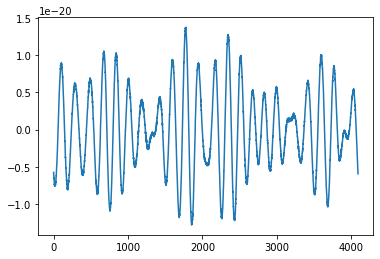

In [36]:
plt.plot(c.flip(-1)[0])

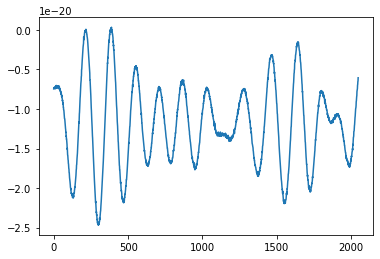

In [37]:
plt.plot((-c.flip(-1)[:,4096-2049:-1]+2*c[:,0].unsqueeze(-1))[0])

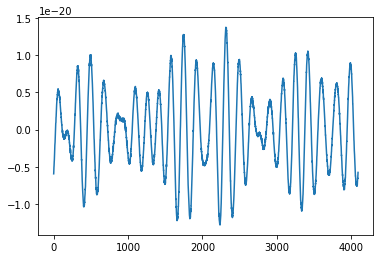

In [38]:
plt.plot(c[0])

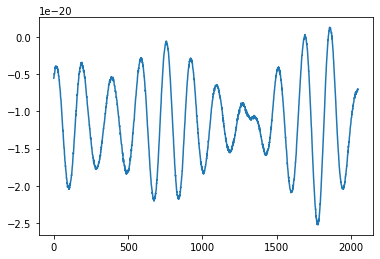

In [39]:
plt.plot((-c.flip(-1)[:,1:2049]+2*c[:,-1].unsqueeze(-1))[0])

In [40]:
c = torch.cat([-c.flip(-1)[:,4096-2049:-1]+2*c[:,0].unsqueeze(-1),c,
                                   -c.flip(-1)[:,1:2049]+2*c[:,-1].unsqueeze(-1)],1)

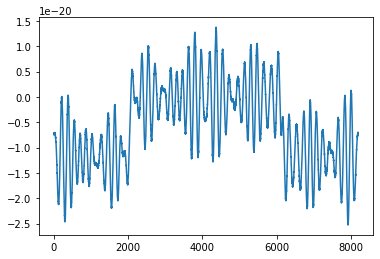

In [41]:
plt.plot(c[0])

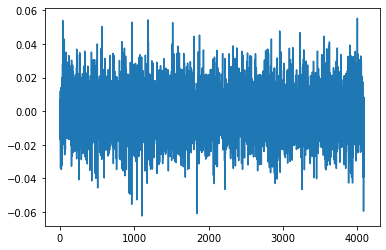

In [42]:

c = torch.fft.ifft(torch.fft.fft((1e20*c*window))/avr_w).real[:,2048:-2048]

plt.plot(c[0])
plt.show()

In [43]:
c.shape

torch.Size([3, 4096])

In [44]:
avr_w_all.shape

torch.Size([32, 3, 8192])

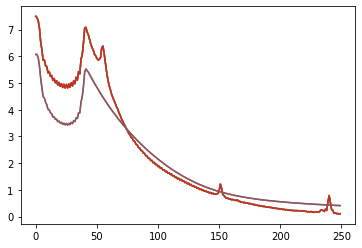

In [45]:
plt.plot(avr_w_all[:16,0].mean(0).log().numpy()[:250])
plt.plot(avr_w_all[16:,0].mean(0).log().numpy()[:250])
plt.plot(avr_w_all[:16,1].mean(0).log().numpy()[:250])
plt.plot(avr_w_all[16:,1].mean(0).log().numpy()[:250])
plt.plot(avr_w_all[:16,2].mean(0).log().numpy()[:250])
plt.plot(avr_w_all[16:,2].mean(0).log().numpy()[:250])
plt.show()

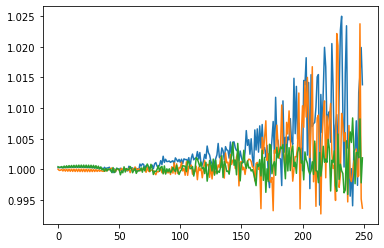

In [46]:
plt.plot(avr_w_all[:16,0].mean(0).log().numpy()[:250] / avr_w_all[16:,0].mean(0).log().numpy()[:250])
plt.plot(avr_w_all[:16,1].mean(0).log().numpy()[:250] / avr_w_all[16:,1].mean(0).log().numpy()[:250])
plt.plot(avr_w_all[:16,2].mean(0).log().numpy()[:250] / avr_w_all[16:,2].mean(0).log().numpy()[:250])
plt.show()

In [55]:
"""The suite of window functions."""

import operator
import warnings

import numpy as np
from scipy import linalg, special, fft as sp_fft

__all__ = ['boxcar', 'triang', 'parzen', 'bohman', 'blackman', 'nuttall',
           'blackmanharris', 'flattop', 'bartlett', 'hanning', 'barthann',
           'hamming', 'kaiser', 'gaussian', 'general_cosine',
           'general_gaussian', 'general_hamming', 'chebwin', 'cosine',
           'hann', 'exponential', 'tukey', 'taylor', 'dpss', 'get_window']


def _len_guards(M):
    """Handle small or incorrect window lengths"""
    if int(M) != M or M < 0:
        raise ValueError('Window length M must be a non-negative integer')
    return M <= 1


def _extend(M, sym):
    """Extend window by 1 sample if needed for DFT-even symmetry"""
    if not sym:
        return M + 1, True
    else:
        return M, False


def _truncate(w, needed):
    """Truncate window by 1 sample if needed for DFT-even symmetry"""
    if needed:
        return w[:-1]
    else:
        return w

def planck(M, alpha=0.5, sym=True):
    r"""Return a Tukey window, also known as a tapered cosine window.
    Parameters
    ----------
    M : int
        Number of points in the output window. If zero or less, an empty
        array is returned.
    alpha : float, optional
        Shape parameter of the Tukey window, representing the fraction of the
        window inside the cosine tapered region.
        If zero, the Tukey window is equivalent to a rectangular window.
        If one, the Tukey window is equivalent to a Hann window.
    sym : bool, optional
        When True (default), generates a symmetric window, for use in filter
        design.
        When False, generates a periodic window, for use in spectral analysis.
    Returns
    -------
    w : ndarray
        The window, with the maximum value normalized to 1 (though the value 1
        does not appear if `M` is even and `sym` is True).
    References
    ----------
    .. [1] Harris, Fredric J. (Jan 1978). "On the use of Windows for Harmonic
           Analysis with the Discrete Fourier Transform". Proceedings of the
           IEEE 66 (1): 51-83. :doi:`10.1109/PROC.1978.10837`
    .. [2] Wikipedia, "Window function",
           https://en.wikipedia.org/wiki/Window_function#Tukey_window
    Examples
    --------
    Plot the window and its frequency response:
    >>> from scipy import signal
    >>> from scipy.fft import fft, fftshift
    >>> import matplotlib.pyplot as plt
    >>> window = signal.windows.tukey(51)
    >>> plt.plot(window)
    >>> plt.title("Tukey window")
    >>> plt.ylabel("Amplitude")
    >>> plt.xlabel("Sample")
    >>> plt.ylim([0, 1.1])
    >>> plt.figure()
    >>> A = fft(window, 2048) / (len(window)/2.0)
    >>> freq = np.linspace(-0.5, 0.5, len(A))
    >>> response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
    >>> plt.plot(freq, response)
    >>> plt.axis([-0.5, 0.5, -120, 0])
    >>> plt.title("Frequency response of the Tukey window")
    >>> plt.ylabel("Normalized magnitude [dB]")
    >>> plt.xlabel("Normalized frequency [cycles per sample]")
    """
    if _len_guards(M):
        return np.ones(M)

    if alpha <= 0:
        return np.ones(M, 'd')
    elif alpha >= 1.0:
        return hann(M, sym=sym)

    M, needs_trunc = _extend(M, sym)

    n = np.arange(0, M)
    width = int(np.floor(alpha*(M-1)))
    n1 = n[1:width+1]
    n2 = n[width+1:M-width-1]
    n3 = n[M-width-1:-1]
    N = M - 1
    w1 = 1/(1+np.exp(alpha*N/n1-alpha*N/(alpha*N-n1)))#0.5 * (1 + np.cos(np.pi * (-1 + 2.0*n1/alpha/(M-1))))
    w2 = np.ones(n2.shape)
    w3 = 1/(1+np.exp(alpha*N/(N-n3)-alpha*N/(alpha*N-N+n3)))#0.5 * (1 + np.cos(np.pi * (-2.0/alpha + 1 + 2.0*n3/alpha/(M-1))))

    w = np.concatenate((np.array([0]),w1, w2, w3, np.array([0])))

    return _truncate(w, needs_trunc)

In [20]:
if Config.window=='tukey':
    window = signal.windows.tukey(4096+2*2048,Config.alpha)
elif Config.window=='planck':
    window = planck(4096+2*2048,Config.alpha)
elif Config.window=='hann':
    window = signal.windows.hann(4096+2*2048)
elif Config.window=='nuttall':
    window = signal.windows.nuttall(4096+2*2048)

In [21]:
window

array([0.0000000e+00, 5.8841780e-07, 2.3536698e-06, ..., 2.3536698e-06,
       5.8841780e-07, 0.0000000e+00])

In [26]:
avr_w_all = torch.load("./avr_w_all.pth")
avr_w = torch.load("./avr_w.pth")
window = torch.FloatTensor(window)
def process_wave(waves, window, avr_w):
    c = torch.FloatTensor(waves)
    c = torch.cat([-c.flip(-1)[:,4096-2049:-1]+2*c[:,0].unsqueeze(-1),c,
                                      -c.flip(-1)[:,1:2049]+2*c[:,-1].unsqueeze(-1)],1)    
    c = torch.fft.ifft(torch.fft.fft((1e20*c*window))/avr_w).real[:,2048:-2048]
    return c.numpy()
# waves = np.load(train.iloc[0,-1])



In [27]:
def save_processed_waves(input_file_path, output_folder, avg_asd=None):
    file_name = input_file_path.split('/')[-1].split('.npy')[0]
    waves = np.load(input_file_path).astype(np.float32) # (3, 4096)
    processed_waves = process_wave(waves, window, avr_w).astype(np.float32)
    np.save(output_folder + file_name, processed_waves)

In [29]:
if Config.whiten_train:
    _ = joblib.Parallel(n_jobs=8)(
        joblib.delayed(save_processed_waves)(input_file_path,Config.output_folder_train) for input_file_path in tqdm(train['file_path'].values)
    )
if Config.whiten_test:
    _ = joblib.Parallel(n_jobs=8)(
        joblib.delayed(save_processed_waves)(input_file_path,Config.output_folder_test) for input_file_path in tqdm(test['file_path'].values)
    )

ValueError: cannot reshape array of size 8176 into shape (3,4096)

In [20]:
train_df

,id,target,file_path,fold,fold_orig
0,00000e74ad,1,./output/whiten-train/00000e74ad.npy,3,1
1,00001f4945,0,./output/whiten-train/00001f4945.npy,0,3
2,0000661522,0,./output/whiten-train/0000661522.npy,4,4
3,00007a006a,0,./output/whiten-train/00007a006a.npy,0,1
4,0000a38978,1,./output/whiten-train/0000a38978.npy,4,1
...,...,...,...,...,...
559995,ffff9a5645,1,./output/whiten-train/ffff9a5645.npy,3,3
559996,ffffab0c27,0,./output/whiten-train/ffffab0c27.npy,1,1
559997,ffffcf161a,1,./output/whiten-train/ffffcf161a.npy,2,4
559998,ffffd2c403,0,./output/whiten-train/ffffd2c403.npy,1,4


In [36]:
# shutil.rmtree(Config.input_train)
shutil.rmtree(Config.input_test)


FileNotFoundError: [Errno 2] No such file or directory: 'test/'

In [35]:
!df -h 

Filesystem      Size  Used Avail Use% Mounted on
overlay          10G  215M  9.8G   3% /
tmpfs            64M     0   64M   0% /dev
tmpfs           126G     0  126G   0% /sys/fs/cgroup
/dev/sdb        200G  106G   95G  53% /home
tmpfs           126G  3.2G  123G   3% /dev/shm
tmpfs           126G     0  126G   0% /proc/asound
tmpfs           126G     0  126G   0% /proc/acpi
tmpfs           126G     0  126G   0% /proc/scsi
tmpfs           126G     0  126G   0% /sys/firmware
